In [1]:
#1
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
import requests
from pathlib import Path
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings("ignore")

In [2]:
#2
# Import API data
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi

In [3]:
#3
# Load .env enviroment variables
load_dotenv("ProjectAPI.env")

True

In [4]:
#4
# The original tickers plus 6 new ones to consider other golbal market, across various sectors compared to the global spy movement  

# Set the tickers
tickers = ["SPY", "IWM", "EZU", "EWU", "EWJ", "EWZ", "EWA", "EWC", "MCHI", "EWW", 'XLK','XLV','XLP','ARKK','ICLN','ROBO']

# Create the shares DataFrame
df_etf = pd.DataFrame(index=tickers)

In [5]:
#5
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("Alpaca_API_Key")
alpaca_secret_key = os.getenv("Alpaca_Secret_Key")

# Verify that Alpaca key and secret were correctly loaded
print(f"Alpaca Key type: {type(alpaca_api_key)}")
print(f"Alpaca Secret Key type: {type(alpaca_secret_key)}")

Alpaca Key type: <class 'str'>
Alpaca Secret Key type: <class 'str'>


In [6]:
#6
# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

In [7]:
#7
# Create current date variable
import datetime
today = datetime.date.today()
historical = today - datetime.timedelta(days=550)

In [8]:
#8
# Format current date as ISO format
# Set start and end datetimes of 18 months
start_date = pd.Timestamp(historical, tz="America/New_York").isoformat()
end_date = pd.Timestamp(today, tz="America/New_York").isoformat()

In [9]:
#8.a
# Set timeframe to 18 months for the Alpaca API
timeframe = "1hour"


In [10]:
#9
# Get 18 months of pricing data for ETF portfolio
df_portfolio = alpaca.get_bars(tickers, timeframe, start=start_date, end=end_date).df

df_portfolio

,close,high,low,trade_count,open,volume,vwap,symbol
timestamp,,,,,,,,
2022-08-29 08:00:00+00:00,41.620,42.25,41.500,245,41.50,26695,41.755178,ARKK
2022-08-29 09:00:00+00:00,41.580,41.70,41.580,86,41.62,7646,41.602435,ARKK
2022-08-29 10:00:00+00:00,41.810,41.81,41.600,98,41.65,22043,41.723959,ARKK
2022-08-29 11:00:00+00:00,41.840,41.95,41.610,787,41.81,74887,41.757857,ARKK
2022-08-29 12:00:00+00:00,41.960,42.08,41.600,1328,41.69,167396,41.911780,ARKK
...,...,...,...,...,...,...,...,...
2024-02-29 18:00:00+00:00,145.205,145.23,145.011,9589,145.11,942698,145.136578,XLV
2024-02-29 19:00:00+00:00,145.085,145.25,145.010,9208,145.21,875856,145.119355,XLV
2024-02-29 20:00:00+00:00,144.730,145.32,144.720,25404,145.09,3035551,145.130996,XLV


In [11]:
#10
# Drop unnecessary columns for our portfolio dataframe
df_portfolio.drop(columns=['high','low','open', 'volume', 'trade_count','vwap'], axis=1, inplace=True)

#Rearrange columns
df_portfolio = df_portfolio[['symbol', 'close']]

df_portfolio

,symbol,close
timestamp,,
2022-08-29 08:00:00+00:00,ARKK,41.620
2022-08-29 09:00:00+00:00,ARKK,41.580
2022-08-29 10:00:00+00:00,ARKK,41.810
2022-08-29 11:00:00+00:00,ARKK,41.840
2022-08-29 12:00:00+00:00,ARKK,41.960
...,...,...
2024-02-29 18:00:00+00:00,XLV,145.205
2024-02-29 19:00:00+00:00,XLV,145.085
2024-02-29 20:00:00+00:00,XLV,144.730


In [12]:
#11
# Reorganize the DataFrame and separate ticker data
# Order:  SPY, EWA, EWC, EWJ, EWU, EWZ, EWW, EZU, IWM, MCHI, 'XLK','XLV','XLP','ARKK','ICLN','ROBO'

# Separate ticker data
SPY = df_portfolio[df_portfolio["symbol"]=="SPY"].drop("symbol", axis=1)
EWA = df_portfolio[df_portfolio["symbol"]=="EWA"].drop("symbol", axis=1)
EWC = df_portfolio[df_portfolio["symbol"]=="EWC"].drop("symbol", axis=1)
EWJ = df_portfolio[df_portfolio["symbol"]=="EWJ"].drop("symbol", axis=1)
EWU = df_portfolio[df_portfolio["symbol"]=="EWU"].drop("symbol", axis=1)
EWZ = df_portfolio[df_portfolio["symbol"]=="EWZ"].drop("symbol", axis=1)
EWW = df_portfolio[df_portfolio["symbol"]=="EWW"].drop("symbol", axis=1)
EZU = df_portfolio[df_portfolio["symbol"]=="EZU"].drop("symbol", axis=1)
IWM = df_portfolio[df_portfolio["symbol"]=="IWM"].drop("symbol", axis=1)
MCHI = df_portfolio[df_portfolio["symbol"]=="MCHI"].drop("symbol", axis=1)
XLK = df_portfolio[df_portfolio["symbol"]=="XLK"].drop("symbol", axis=1)
XLV = df_portfolio[df_portfolio["symbol"]=="XLV"].drop("symbol", axis=1)
XLP = df_portfolio[df_portfolio["symbol"]=="XLP"].drop("symbol", axis=1)
ARKK = df_portfolio[df_portfolio["symbol"]=="ARKK"].drop("symbol", axis=1)
ICLN = df_portfolio[df_portfolio["symbol"]=="ICLN"].drop("symbol", axis=1)
ROBO = df_portfolio[df_portfolio["symbol"]=="ROBO"].drop("symbol", axis=1)

# Concatenate the ticker DataFrames
df_portreo = pd.concat([SPY, EWA, EWC, EWJ, EWU, EWZ, EWW, EZU, IWM, MCHI, XLK, XLV, XLP, ARKK, ICLN, ROBO], axis=1)

# Rename columns
df_portreo.columns=['SPY_close', 'EWA_close', 'EWC_close', 'EWJ_close', 'EWU_close', 'EWZ_close', 'EWW_close', 'EZU_close', 'IWM_close', 'MCHI_close','XLK_close', 'XLV_close', 'XLP_close', 'ARKK_close', 'ICLN_close', 'ROBO_close']
# Display sample data
df_portreo.dropna(inplace=True)
df_portreo

,SPY_close,EWA_close,EWC_close,EWJ_close,EWU_close,EWZ_close,EWW_close,EZU_close,IWM_close,MCHI_close,XLK_close,XLV_close,XLP_close,ARKK_close,ICLN_close,ROBO_close
timestamp,,,,,,,,,,,,,,,,
2022-08-29 13:00:00+00:00,402.814,22.370,34.930,53.9800,29.7350,32.1150,46.450,35.6900,187.82,50.6900,138.67,126.080,73.930,42.7100,22.560,47.9100
2022-08-29 14:00:00+00:00,401.400,22.270,34.860,53.8191,29.6952,32.3600,46.060,35.5875,187.29,50.2900,137.68,125.845,74.045,42.3700,22.415,47.6199
2022-08-29 15:00:00+00:00,403.370,22.385,34.970,53.9700,29.8200,32.5500,46.000,35.7000,187.89,50.1550,138.25,126.460,74.430,42.4700,22.440,47.7000
2022-08-29 16:00:00+00:00,404.620,22.425,35.010,54.0550,29.8300,32.5600,46.235,35.8550,188.22,50.1971,138.74,126.890,74.575,42.6200,22.490,47.8600
2022-08-29 17:00:00+00:00,405.080,22.430,35.045,54.0350,29.8400,32.6550,46.260,35.8301,188.72,50.1900,138.86,126.985,74.560,42.8934,22.540,47.8800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-29 17:00:00+00:00,507.375,23.845,36.710,68.9150,32.6450,33.0200,65.175,48.9050,203.61,39.0150,206.06,145.095,74.625,51.0101,13.875,57.3099
2024-02-29 18:00:00+00:00,507.800,23.885,36.770,69.0450,32.7000,32.9900,65.470,48.9750,203.83,39.0550,206.34,145.205,74.535,51.0000,13.965,57.3100
2024-02-29 19:00:00+00:00,507.750,23.860,36.740,68.9900,32.6750,32.9359,65.340,48.9597,203.37,39.0450,206.44,145.085,74.545,50.9600,13.910,57.3215


In [13]:
#11.a
#Define Features and target

X = df_portreo.drop(columns='SPY_close').shift(1).dropna()
y = df_portreo['SPY_close'][1:]
X

,EWA_close,EWC_close,EWJ_close,EWU_close,EWZ_close,EWW_close,EZU_close,IWM_close,MCHI_close,XLK_close,XLV_close,XLP_close,ARKK_close,ICLN_close,ROBO_close
timestamp,,,,,,,,,,,,,,,
2022-08-29 14:00:00+00:00,22.370,34.930,53.9800,29.7350,32.1150,46.450,35.6900,187.820,50.6900,138.67,126.080,73.930,42.7100,22.560,47.9100
2022-08-29 15:00:00+00:00,22.270,34.860,53.8191,29.6952,32.3600,46.060,35.5875,187.290,50.2900,137.68,125.845,74.045,42.3700,22.415,47.6199
2022-08-29 16:00:00+00:00,22.385,34.970,53.9700,29.8200,32.5500,46.000,35.7000,187.890,50.1550,138.25,126.460,74.430,42.4700,22.440,47.7000
2022-08-29 17:00:00+00:00,22.425,35.010,54.0550,29.8300,32.5600,46.235,35.8550,188.220,50.1971,138.74,126.890,74.575,42.6200,22.490,47.8600
2022-08-29 18:00:00+00:00,22.430,35.045,54.0350,29.8400,32.6550,46.260,35.8301,188.720,50.1900,138.86,126.985,74.560,42.8934,22.540,47.8800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-29 17:00:00+00:00,23.835,36.715,68.9050,32.6000,33.0150,65.155,48.8500,203.445,39.0350,205.67,145.020,74.500,51.0800,13.845,57.2400
2024-02-29 18:00:00+00:00,23.845,36.710,68.9150,32.6450,33.0200,65.175,48.9050,203.610,39.0150,206.06,145.095,74.625,51.0101,13.875,57.3099
2024-02-29 19:00:00+00:00,23.885,36.770,69.0450,32.7000,32.9900,65.470,48.9750,203.830,39.0550,206.34,145.205,74.535,51.0000,13.965,57.3100


In [14]:
#12
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
scaler = StandardScaler()
scaler.fit(X_train)  
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


In [15]:
#13
#Define model and parmeters
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
SGDmodel = SGDRegressor(max_iter = int(np.ceil(10**6 // len('SPY_close'))), random_state=1)  

#Fit Model
SGDmodel.fit(X_train, y_train)

#Make Predictions
SGDpredictions = SGDmodel.predict(X_test)

score = SGDmodel.score(X_train, y_train)
mse = mean_squared_error(y_test, SGDpredictions)

print(f"R Squared is {score}")
print("Mean Squared Error: ", mse)
print("RMSE: ", mse**(1/2.0))

R Squared is 0.9966869581174205
Mean Squared Error:  4.247824329495329
RMSE:  2.0610250676533095


<Axes: xlabel='timestamp'>

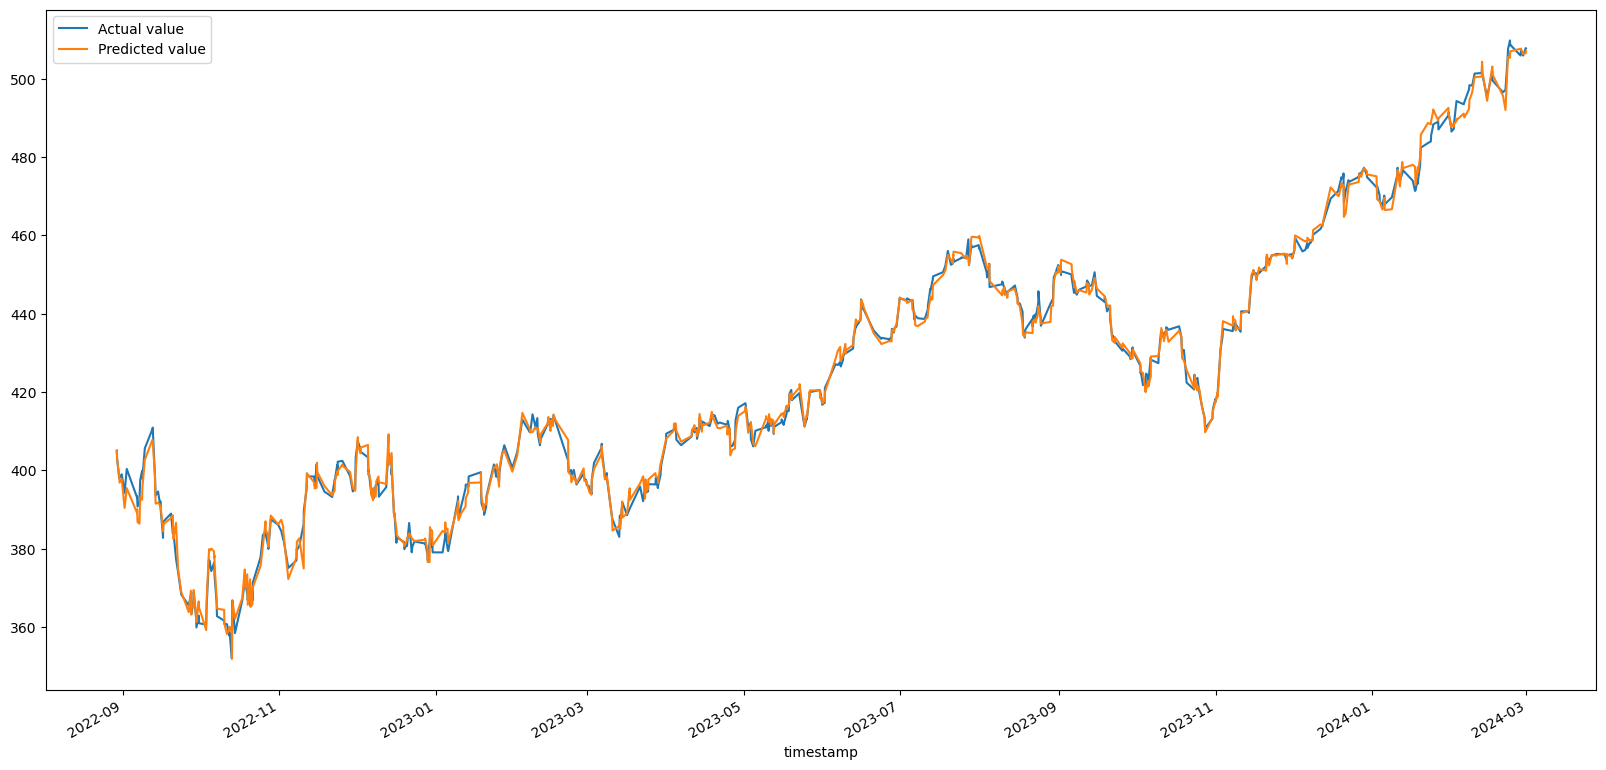

In [17]:
reg_model_diff = pd.DataFrame({'Actual value': y_test, 'Predicted value': SGDpredictions})
reg_model_diff.plot(figsize=(20,10))

In [18]:
predict_df = pd.DataFrame(X, columns=['EWA_close', 'EWC_close', 'EWJ_close', 'EWU_close', 'EWZ_close', 'EWW_close', 'EZU_close', 'IWM_close', 'MCHI_close','XLK_close', 'XLV_close', 'XLP_close', 'ARKK_close', 'ICLN_close', 'ROBO_close'])
predict_df_scaled = pd.DataFrame(scaler.transform(predict_df))
last_rows = predict_df_scaled.tail(1)
#last_rows = scaler.transform(last_rows)
SGDnext = SGDmodel.predict(last_rows)
SGD_final = (SGDnext-df_portreo['SPY_close'].tail(1))/df_portreo['SPY_close'].tail(1) 
print(SGD_final)

timestamp
2024-02-29 21:00:00+00:00   -0.002429
Name: SPY_close, dtype: float64


In [19]:
predict_df_scaled['predicted_value'] = SGDmodel.predict(predict_df_scaled)
predict_df_scaled['pct_change'] = predict_df_scaled['predicted_value'].pct_change()
predict_df_scaled.dropna(inplace=True)
predict_df_scaled['signals'] = 0
predict_df_scaled.loc[predict_df_scaled['pct_change'] > 0.002,'signals'] = 1
predict_df_scaled.loc[predict_df_scaled['pct_change'] < -0.002,'signals'] = -1
predict_df_scaled

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,predicted_value,pct_change,signals
1,-0.221373,0.376876,-1.094560,-1.056242,0.677974,-1.958193,-1.797611,0.460133,1.247076,-0.812502,-1.295092,0.540485,0.229875,1.801333,-0.904861,401.950728,-0.003404,-1
2,-0.120215,0.457145,-1.062557,-0.985101,0.762212,-1.967812,-1.770243,0.523431,1.215947,-0.789543,-1.173035,0.692341,0.249317,1.810762,-0.887195,403.429915,0.003680,1
3,-0.085030,0.486334,-1.044530,-0.979400,0.766645,-1.930136,-1.732536,0.558245,1.225654,-0.769806,-1.087695,0.749533,0.278480,1.829620,-0.851907,404.463015,0.002561,1
4,-0.080632,0.511874,-1.048772,-0.973700,0.808764,-1.926128,-1.738593,0.610993,1.224017,-0.764973,-1.068841,0.743616,0.331635,1.848477,-0.847496,404.945226,0.001192,0
5,-0.120215,0.471740,-1.058315,-1.002202,0.771079,-1.929334,-1.755647,0.560355,1.214794,-0.774639,-1.071818,0.763338,0.263102,1.810762,-0.898223,404.571365,-0.000923,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2984,1.155250,1.730509,2.104842,0.599606,0.968374,1.103178,1.428800,2.164426,-1.348209,1.926054,2.510493,0.719951,1.923273,-1.430850,1.216880,506.069015,-0.001318,0
2985,1.164046,1.726860,2.106963,0.625258,0.970590,1.106384,1.442180,2.181833,-1.352820,1.941762,2.525378,0.769254,1.909683,-1.419535,1.232296,506.518846,0.000889,0
2986,1.199231,1.770644,2.134533,0.656610,0.957290,1.153679,1.459210,2.205042,-1.343597,1.953040,2.547209,0.733756,1.907720,-1.385592,1.232318,507.015502,0.000981,0
2987,1.177240,1.748752,2.122869,0.642359,0.933304,1.132837,1.455487,2.156513,-1.345903,1.957068,2.523393,0.737700,1.899943,-1.406335,1.234855,506.793056,-0.000439,0


In [20]:
#test
initial_capital = float(10000)
share_size = float(24)

predict_df_scaled["signal_diff"] = predict_df_scaled['signals'].diff()

predict_df_scaled['Entry/Exit Position'] = 0
predict_df_scaled['Trade Costs or Proceeds'] = 0
predict_df_scaled['Position'] = 0

Portfolio_Cash = initial_capital
held_shares = 0 
current_shares = 0
k = 0
j = 0
for index, row in predict_df_scaled.iterrows():
    max_share_size = (Portfolio_Cash//predict_df_scaled['predicted_value'].at[index])
    if index == 1:
        predict_df_scaled["Portfolio Cash"] = float(10000)
    
    elif (row['signals'] > 0) and (max_share_size > 0): 
        predict_df_scaled['Entry/Exit Position'].at[index] =  max_share_size
        predict_df_scaled['Trade Costs or Proceeds'].at[index] = -(predict_df_scaled['predicted_value'].at[index] * predict_df_scaled['Entry/Exit Position'].at[index])
        predict_df_scaled["Portfolio Cash"].at[index] = Portfolio_Cash + (predict_df_scaled['Trade Costs or Proceeds'].at[index]).cumsum()
        Portfolio_Cash =  predict_df_scaled["Portfolio Cash"].at[index]
        held_shares += predict_df_scaled['Entry/Exit Position'].at[index]
        share_size = max_share_size
        j = 0
        
    elif (row['signals'] < 0) and (held_shares > 0):
        if k == 0:
            k += 1
            predict_df_scaled['Trade Costs or Proceeds'].at[index] = -(predict_df_scaled['predicted_value'].at[index] * predict_df_scaled['Entry/Exit Position'].at[index])
            predict_df_scaled["Portfolio Cash"].at[index] = predict_df_scaled["Portfolio Cash"].at[index-1] + (predict_df_scaled['Trade Costs or Proceeds'].at[index]).cumsum()
        else:
            predict_df_scaled['Entry/Exit Position'].at[index] = -(held_shares)
            predict_df_scaled['Trade Costs or Proceeds'].at[index] = -(predict_df_scaled['predicted_value'].at[index] * predict_df_scaled['Entry/Exit Position'].at[index])
            predict_df_scaled["Portfolio Cash"].at[index] = predict_df_scaled["Portfolio Cash"].at[index-1] + (predict_df_scaled['Trade Costs or Proceeds'].at[index]).cumsum()
            Portfolio_Cash =  predict_df_scaled["Portfolio Cash"].at[index]
            held_shares = 0
            share_size = max_share_size
            k = 0
    else:
        predict_df_scaled["Portfolio Cash"].at[index] = predict_df_scaled["Portfolio Cash"].at[index-1]


for index, row in predict_df_scaled.iterrows():
    if row['Entry/Exit Position'] > 0:
        predict_df_scaled['Position'].at[index] = current_shares + row['Entry/Exit Position']
        current_shares = predict_df_scaled['Position'].at[index]
    elif row['Entry/Exit Position'] < 0:
        predict_df_scaled['Position'].at[index] = current_shares + row['Entry/Exit Position'] 
        current_shares = predict_df_scaled['Position'].at[index]
    else:
        predict_df_scaled['Position'].at[index] = current_shares
      

    
predict_df_scaled["Stock Holdings"] = (predict_df_scaled["predicted_value"] * predict_df_scaled["Position"])

predict_df_scaled["Portfolio Total"] = predict_df_scaled['Portfolio Cash'] + predict_df_scaled['Stock Holdings']

predict_df_scaled["Portfolio Daily Returns"] = predict_df_scaled['Portfolio Total'].pct_change()

predict_df_scaled["Portfolio Cumulative Returns"] = (predict_df_scaled['Portfolio Total'] - initial_capital)/initial_capital  #(1 + predict_df_scaled['Portfolio Daily Returns']).cumprod() - 1

predict_df_scaled.dropna(inplace=True)

predict_df_scaled.iloc[:,14:].head()


,14,predicted_value,pct_change,signals,signal_diff,Entry/Exit Position,Trade Costs or Proceeds,Position,Portfolio Cash,Stock Holdings,Portfolio Total,Portfolio Daily Returns,Portfolio Cumulative Returns
2,-0.887195,403.429915,0.003680,1,2.0,24,-9682.317953,24,317.682047,9682.317953,10000.000000,0.000000,0.000000
3,-0.851907,404.463015,0.002561,1,0.0,0,0.000000,24,317.682047,9707.112349,10024.794396,0.002479,0.002479
4,-0.847496,404.945226,0.001192,0,-1.0,0,0.000000,24,317.682047,9718.685413,10036.367461,0.001154,0.003637
5,-0.898223,404.571365,-0.000923,0,0.0,0,0.000000,24,317.682047,9709.712754,10027.394801,-0.000894,0.002739
6,-0.911456,402.858842,-0.004233,-1,-1.0,0,-0.000000,24,317.682047,9668.612209,9986.294256,-0.004099,-0.001371


In [21]:
predict_df_scaled.tail()

,0,1,2,3,4,5,6,7,8,9,...,signals,signal_diff,Entry/Exit Position,Trade Costs or Proceeds,Position,Portfolio Cash,Stock Holdings,Portfolio Total,Portfolio Daily Returns,Portfolio Cumulative Returns
2984,1.155250,1.730509,2.104842,0.599606,0.968374,1.103178,1.428800,2.164426,-1.348209,1.926054,...,0,1.0,0,0.0,25,49.053502,12651.725364,12700.778867,-0.001313,0.270078
2985,1.164046,1.726860,2.106963,0.625258,0.970590,1.106384,1.442180,2.181833,-1.352820,1.941762,...,0,0.0,0,0.0,25,49.053502,12662.971153,12712.024655,0.000885,0.271202
2986,1.199231,1.770644,2.134533,0.656610,0.957290,1.153679,1.459210,2.205042,-1.343597,1.953040,...,0,0.0,0,0.0,25,49.053502,12675.387550,12724.441052,0.000977,0.272444
2987,1.177240,1.748752,2.122869,0.642359,0.933304,1.132837,1.455487,2.156513,-1.345903,1.957068,...,0,0.0,0,0.0,25,49.053502,12669.826389,12718.879891,-0.000437,0.271888
2988,1.230018,1.770644,2.149909,0.679412,0.961723,1.116805,1.474414,2.183942,-1.359738,1.977208,...,0,0.0,0,0.0,25,49.053502,12679.131840,12728.185343,0.000732,0.272819


In [22]:
predict_df_scaled['Portfolio Total'].iloc[-1]

12728.185342727964

In [23]:
#15
#Set logic for signal
if SGDnext > 0.005:
    SGDprediction = 1
elif SGDnext < -0.005:
    SGDprediction = -1
elif -0.005 <= SGDnext <= 0.005:
    SGDprediction = 0
    
SGDprediction

1

In [ ]:
'''
#Prophet Model Section, no good prediction#

#14
import pandas as pd
import holoviews as hv
from prophet import Prophet
import hvplot.pandas
import seaborn as sns
from datetime import datetime, timezone
%matplotlib inline

interim = df_portreo.copy()
interim.reset_index(inplace=True)
prophet_model = interim[['timestamp', 'SPY_close']]
prophet_model['timestamp'] = prophet_model['timestamp'].apply(lambda d: d.replace(tzinfo=None))
prophet_model.rename(columns={"timestamp":"ds", "SPY_close":"y"}, inplace=True)

#display(prophet_model)


#Plotting Trends Dataframe'

display(prophet_model.hvplot(title= "Trends", xlabel="Date",ylabel="Closing Prices", xticks="symbol"))


Prophet_trends=Prophet()

Prophet_trends.fit(prophet_model)

Prophet_trends_forecast = Prophet_trends.make_future_dataframe(periods=365, freq='D')
#Prophet_trends_forecast
forecast = Prophet_trends.predict(Prophet_trends_forecast)
forecast

forecast[['yhat', 'yhat_lower', 'yhat_upper']].hvplot()
fig2 = Prophet_trends.plot_components(forecast)
'''

In [25]:
# import libraries (potentially remove this block of code if redundant)
import pandas as pd
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


In [26]:
df_portreo['SPY_pct'] = df_portreo['SPY_close'].pct_change().dropna()

In [27]:
df_portreo.dropna(inplace=True)

In [28]:
df_portreo.loc[df_portreo['SPY_pct'] > 0.005,'y'] = 1
df_portreo.loc[df_portreo['SPY_pct'] < -0.005,'y'] = -1
df_portreo

,SPY_close,EWA_close,EWC_close,EWJ_close,EWU_close,EWZ_close,EWW_close,EZU_close,IWM_close,MCHI_close,XLK_close,XLV_close,XLP_close,ARKK_close,ICLN_close,ROBO_close,SPY_pct,y
timestamp,,,,,,,,,,,,,,,,,,
2022-08-29 14:00:00+00:00,401.400,22.270,34.860,53.8191,29.6952,32.3600,46.060,35.5875,187.29,50.2900,137.68,125.845,74.045,42.3700,22.415,47.6199,-0.003510,NaN
2022-08-29 15:00:00+00:00,403.370,22.385,34.970,53.9700,29.8200,32.5500,46.000,35.7000,187.89,50.1550,138.25,126.460,74.430,42.4700,22.440,47.7000,0.004908,NaN
2022-08-29 16:00:00+00:00,404.620,22.425,35.010,54.0550,29.8300,32.5600,46.235,35.8550,188.22,50.1971,138.74,126.890,74.575,42.6200,22.490,47.8600,0.003099,NaN
2022-08-29 17:00:00+00:00,405.080,22.430,35.045,54.0350,29.8400,32.6550,46.260,35.8301,188.72,50.1900,138.86,126.985,74.560,42.8934,22.540,47.8800,0.001137,NaN
2022-08-29 18:00:00+00:00,404.600,22.385,34.990,53.9900,29.7900,32.5700,46.240,35.7600,188.24,50.1500,138.62,126.970,74.610,42.5409,22.440,47.6500,-0.001185,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-29 17:00:00+00:00,507.375,23.845,36.710,68.9150,32.6450,33.0200,65.175,48.9050,203.61,39.0150,206.06,145.095,74.625,51.0101,13.875,57.3099,0.001431,NaN
2024-02-29 18:00:00+00:00,507.800,23.885,36.770,69.0450,32.7000,32.9900,65.470,48.9750,203.83,39.0550,206.34,145.205,74.535,51.0000,13.965,57.3100,0.000838,NaN
2024-02-29 19:00:00+00:00,507.750,23.860,36.740,68.9900,32.6750,32.9359,65.340,48.9597,203.37,39.0450,206.44,145.085,74.545,50.9600,13.910,57.3215,-0.000098,NaN


In [29]:
X = df_portreo.drop(columns=['SPY_close', 'SPY_pct', 'y'])
y = df_portreo['y']


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
scaler = StandardScaler()
scaler.fit(X_train)  
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


In [30]:
#16
number_inputs = 15
number_hidden_nodes = 8
neuron = Sequential()
neuron.add(Dense(units=number_hidden_nodes, input_dim=number_inputs, activation="relu"))

# Add the output layer to the model specifying the number of output neurons and activation function
neuron.add(Dense(1, activation="Softmax"))


In [31]:
#17
neuron.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 128       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 137 (548.00 Byte)
Trainable params: 137 (548.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [32]:
#18# Compile the Sequential model
neuron.compile(loss="CategoricalCrossentropy", optimizer="adam", metrics=["accuracy"])

In [33]:
#19
# Fit the model using 100 epochs and the training data
model = neuron.fit(X_train, y_train, epochs=100)

Epoch 1/100


71/71 [==============================] - 1s 687us/step - loss: nan - accuracy: 8.9246e-04
Epoch 2/100
71/71 [==============================] - 0s 456us/step - loss: nan - accuracy: 0.0000e+00
Epoch 3/100
71/71 [==============================] - 0s 464us/step - loss: nan - accuracy: 0.0000e+00
Epoch 4/100
71/71 [==============================] - 0s 670us/step - loss: nan - accuracy: 0.0000e+00
Epoch 5/100
71/71 [==============================] - 0s 444us/step - loss: nan - accuracy: 0.0000e+00
Epoch 6/100
71/71 [==============================] - 0s 662us/step - loss: nan - accuracy: 0.0000e+00
Epoch 7/100
71/71 [==============================] - 0s 664us/step - loss: nan - accuracy: 0.0000e+00
Epoch 8/100
71/71 [==============================] - 0s 654us/step - loss: nan - accuracy: 0.0000e+00
Epoch 9/100
71/71 [==============================] - 0s 675us/step - loss: nan - accuracy: 0.0000e+00
Epoch 10/100
71/71 [==============================] - 0s 651us/step - loss: nan 

In [ ]:
#20

In [ ]:
#21

In [ ]:
#22

In [ ]:
#23

In [ ]:
#24